In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")


In [2]:
df = pd.read_csv("stock_data.csv", parse_dates=["Date"])

In [3]:
df.head()

,Date,Stock,Open,High,Low,Close,Volume,SMA_50,Close_Lag_1,Close_Lag_3,Close_Lag_7,SMA_7,SMA_30,Daily_Return
0,2024-01-02,AAPL,184.532089,187.315382,182.792533,186.033072,82488700,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-01-02,AMZN,149.929993,152.380005,148.389999,151.539993,47339400,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-01-02,GOOGL,137.670929,138.946304,135.987031,138.049561,23711200,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-01-02,MSFT,367.380585,372.363258,363.319154,370.342443,25258600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-01-02,TSLA,248.419998,251.250000,244.410004,250.080002,104654200,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df = df[df["Stock"] == "AAPL"].copy()
df.set_index("Date", inplace=True)
df = df.sort_index()


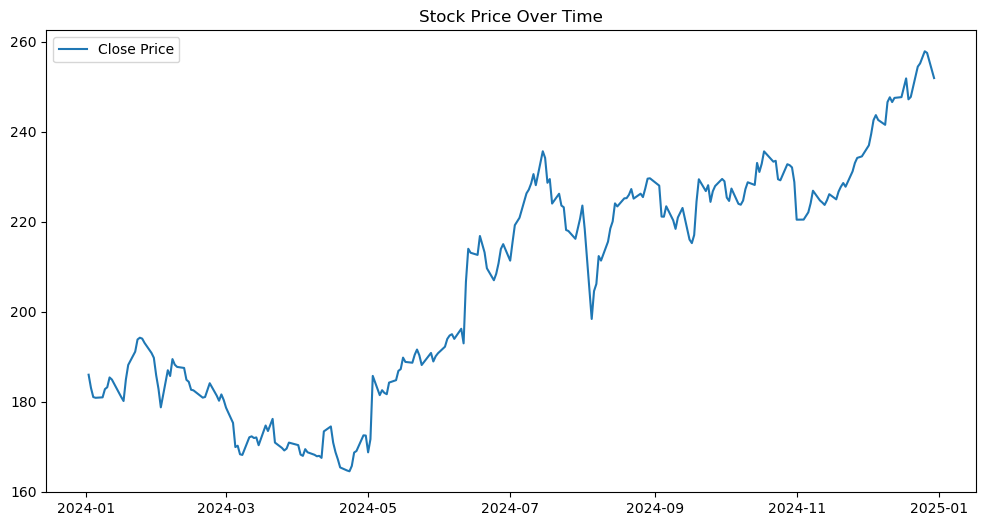

In [5]:
ts = df["Close"]
plt.figure(figsize=(12,6))
plt.plot(ts, label="Close Price")
plt.title("Stock Price Over Time")
plt.legend()
plt.show()


In [6]:
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is NOT stationary.")

adf_test(ts)


ADF Statistic: -0.3308378976720049
p-value: 0.9210217844206035
The time series is NOT stationary.


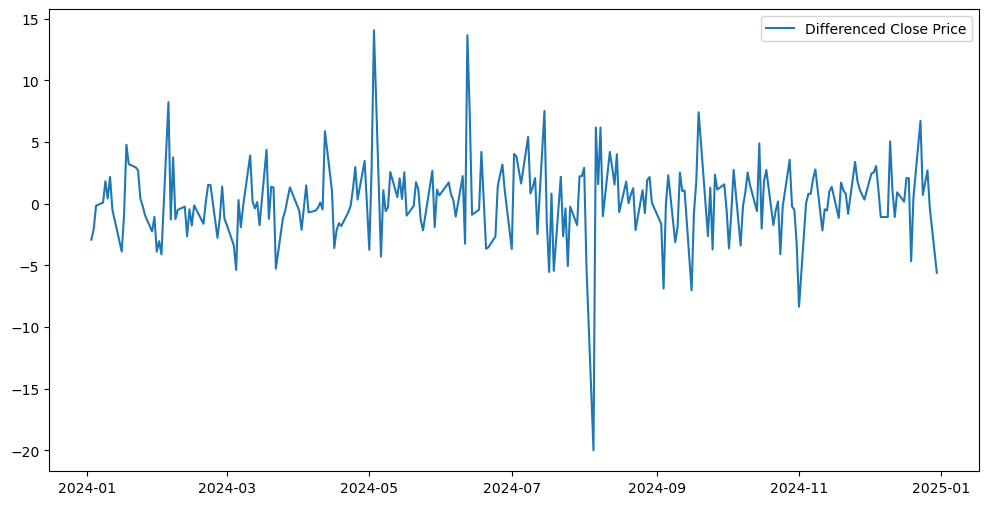

ADF Statistic: -15.075841060181713
p-value: 8.593227809057714e-28
The time series is stationary.


In [7]:
ts_diff = ts.diff().dropna()
plt.figure(figsize=(12,6))
plt.plot(ts_diff, label="Differenced Close Price")
plt.legend()
plt.show()

adf_test(ts_diff)


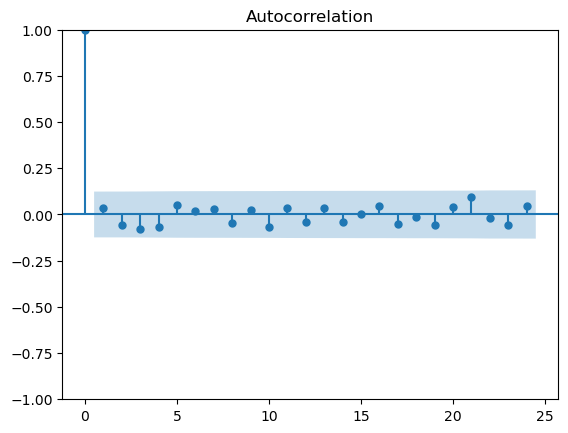

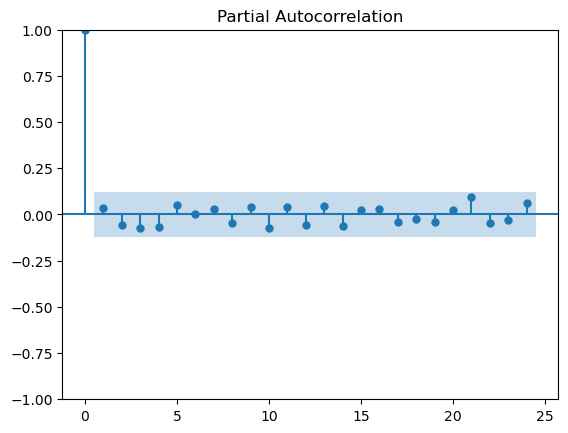

In [8]:
plot_acf(ts_diff)
plot_pacf(ts_diff)
plt.show()


In [9]:
from pmdarima import auto_arima

auto_arima_model = auto_arima(ts, seasonal=False, stepwise=True, trace=True)
auto_arima_model.summary()


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1298.595, Time=0.40 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1294.306, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1295.972, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1295.930, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1294.002, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.343 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  251
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -646.001
Date:                Tue, 04 Mar 2025   AIC                           1294.002
Time:                        23:49:59   BIC                           1297.524
Sample:                             0   HQIC                          1295.420
                                - 251                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        10.2793      0.419     24.555      0.000       9.459      11.100
===================================================================================
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               656.58
Prob(Q):                              0.56   Prob(JB):                         0.00
Heteroskedasticity (H):               1.37   Skew:                            -0.43
Prob(H) (two-sided):                  0.15   Kurtosis:                        10.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
p, d, q = 0, 1, 0  # Update with auto_arima results
arima_model = ARIMA(ts, order=(p, d, q))
arima_result = arima_model.fit()
print(arima_result.summary())


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  251
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -646.001
Date:                Tue, 04 Mar 2025   AIC                           1294.002
Time:                        23:50:27   BIC                           1297.524
Sample:                             0   HQIC                          1295.420
                                - 251                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        10.2793      0.419     24.555      0.000       9.459      11.100
Ljung-Box (L1) (Q):                   0.33   Jarque-Bera (JB):               656.58
Prob(Q):                              0.56   Pr

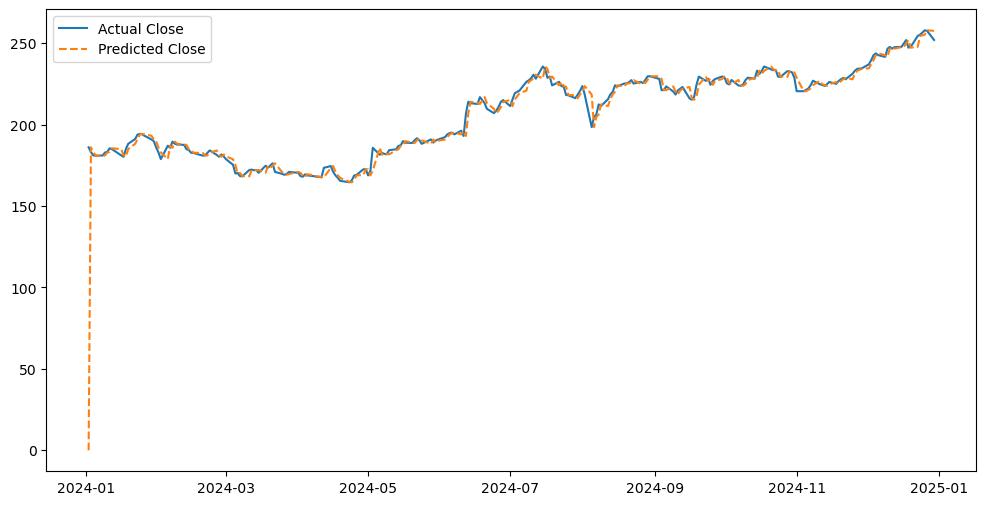

In [11]:
df["Predicted"] = arima_result.predict(start=ts.index[0], end=ts.index[-1], dynamic=False)

plt.figure(figsize=(12,6))
plt.plot(df["Close"], label="Actual Close")
plt.plot(df["Predicted"], label="Predicted Close", linestyle="dashed")
plt.legend()
plt.show()


In [12]:
rmse = np.sqrt(mean_squared_error(df["Close"].iloc[1:], df["Predicted"].iloc[1:]))
print(f"RMSE: {rmse}")


RMSE: 3.2061353094029124


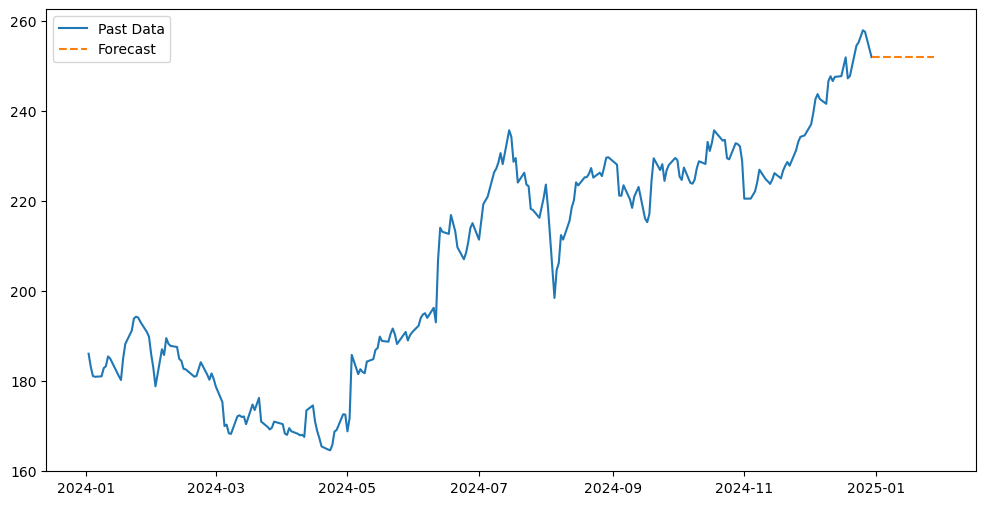

In [13]:
forecast_steps = 30
forecast = arima_result.forecast(steps=forecast_steps)

plt.figure(figsize=(12,6))
plt.plot(ts, label="Past Data")
plt.plot(pd.date_range(ts.index[-1], periods=forecast_steps, freq="D"), forecast, label="Forecast", linestyle="dashed")
plt.legend()
plt.show()


In [15]:
test = ts[-forecast_steps:]  # Last 'forecast_steps' values as test set


In [16]:
from sklearn.metrics import mean_absolute_error

# Ensure your test data is properly defined
actual = test.values  # Replace 'test' with your actual test dataset
predicted = forecast  # Forecasted values

# Calculate MAE
mae = mean_absolute_error(actual, predicted)

# Calculate MAPE (handling division by zero)
mape = (abs(actual - predicted) / actual).mean() * 100

print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")


MAE: 11.3675
MAPE: 4.85%
